In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
from tqdm import tqdm
import torchdiffeq
import pygot
import pandas as pd
import seaborn as sns
import cospar as cs
from help_function import cell_fate_helper as hf
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
%matplotlib inline


In [2]:
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
 
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True


## Loading Data

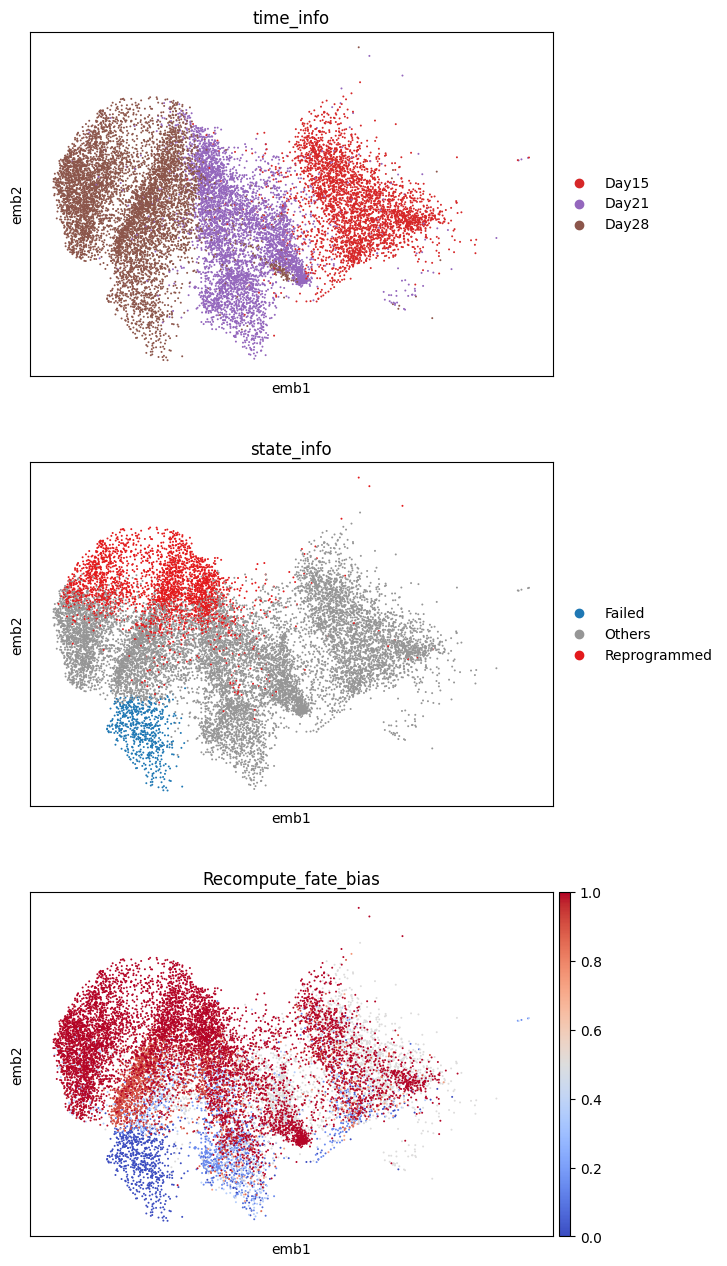

In [3]:
adata = sc.read_h5ad("../pygot_data/03_cellfate/adata_repro.h5ad")

time_key = 'time_info'
cell_type_key = 'state_info'
embedding_key = 'X_pca'
sc.pl.embedding(adata,basis='emb',color=[time_key, cell_type_key, 'Recompute_fate_bias'], color_map='coolwarm',ncols=1)
dim = 30
adata.obsm[embedding_key] = adata.obsm[embedding_key][:,:dim]
#adata.varm['PCs'] = adata.varm['PCs'][:, :dim]
adata = adata[adata.obs.sort_values(time_key).index]


ts = np.sort(np.unique(adata.obs[time_key]))
ts_map = dict(zip(ts, range(len(ts))))
adata.obs['time_label'] = adata.obs[time_key].replace(ts_map).astype(int)
#x0_adata = adata[ (adata.obs['time_label'] < 2) & (adata.obs['benchmark'] == True)]

embedding_key = 'X_pca'
velocity_key = 'velocity_pca'
time_key = 'time_label' 

## Compute Ground Truth based on Clonal Information

Infer transition map between neighboring time points.
--> Clonal cell fraction (day Day15-Day21): 0.805352798053528
--> Clonal cell fraction (day Day21-Day28): 0.8049918831168831
--> Clonal cell fraction (day Day21-Day15): 0.8952922077922078
--> Clonal cell fraction (day Day28-Day21): 0.9663468859448759
--> Numer of cells that are clonally related -- day Day15: 2648  and day Day21: 4412
--> Numer of cells that are clonally related -- day Day21: 3967  and day Day28: 6346
Number of multi-time clones post selection: 440
Cell number=14783, Clone number=440
--> clonal_cell_id_t1: 6615
--> Tmap_cell_id_t1: 8216
Use all clones (naive method)
Use all clones (naive method)
Results saved at adata.obs['fate_map_clonal_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_clonal_transition_map_Failed']


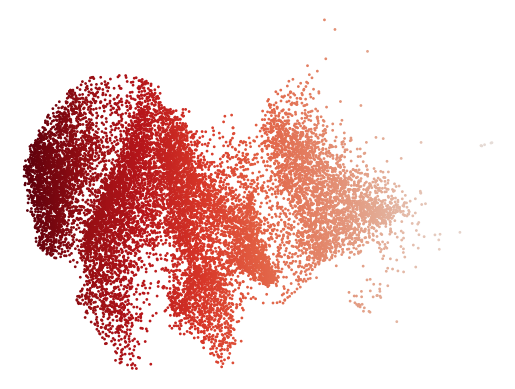

In [4]:

adata_processed = cs.tmap.infer_Tmap_from_clonal_info_alone(
    adata,      
)
cs.tl.fate_map(
    adata_processed,
    selected_fates=["Reprogrammed", "Failed"],
    source="clonal_transition_map",
    map_backward=True,
    method="norm-sum",
    
)
adata_processed.obs['Cospar_fate_bias'] = adata_processed.obs['fate_map_clonal_transition_map_Reprogrammed'] / (adata_processed.obs['fate_map_clonal_transition_map_Reprogrammed'] + adata_processed.obs['fate_map_clonal_transition_map_Failed'])

x0_adata = adata_processed[~np.isnan(adata_processed.obs['Cospar_fate_bias'])]
x0_adata = x0_adata[x0_adata.obs['benchmark']]

groundtruth_key = 'Cospar_fate_bias'

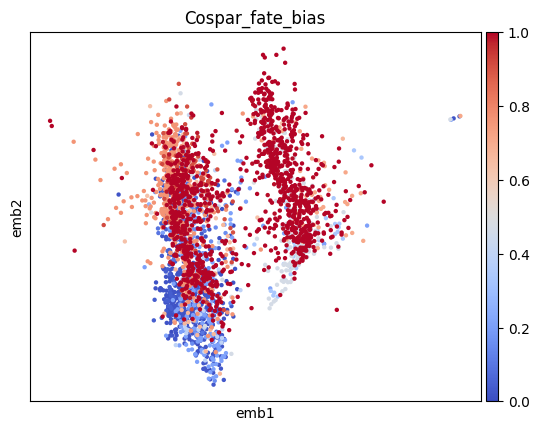

In [5]:
sc.pl.embedding(x0_adata, color=groundtruth_key, basis='emb', cmap='coolwarm')

## Training model

### GOT

In [264]:
gots = []
for i in range(10):
    model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key=embedding_key, path='./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/', 
                                       device=device, x_centric_iter_n=3000, time_varying=True)
    gots.append(model)

loading saved shortest path profile
[Errno 2] No such file or directory: './benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30//_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3288/3288 [00:12<00:00, 272.11it/s]


calcu shortest path between 1 to 2


loss :140.6717  best :140.6717: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:11<00:00, 42.25it/s]


loading saved shortest path profile


loss :142.0304  best :142.0304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:11<00:00, 42.16it/s]


loading saved shortest path profile


loss :144.5781  best :144.1008: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:10<00:00, 42.76it/s]


loading saved shortest path profile


loss :142.5624  best :141.3395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:10<00:00, 42.78it/s]


loading saved shortest path profile


loss :142.6977  best :142.2942: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:15<00:00, 39.59it/s]


loading saved shortest path profile


loss :144.2502  best :142.0379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:12<00:00, 41.53it/s]


loading saved shortest path profile


loss :143.2506  best :142.0833: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:10<00:00, 42.28it/s]


loading saved shortest path profile


loss :145.2112  best :141.7364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:13<00:00, 40.70it/s]


loading saved shortest path profile


loss :141.6470  best :140.0628: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:15<00:00, 39.95it/s]


loading saved shortest path profile


loss :141.5733  best :141.4284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:14<00:00, 40.52it/s]


In [ ]:
for i, got in enumerate(gots):
    os.system('mkdir ./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/'+str(i))
    torch.save(got, './benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/'+str(i)+'/got.pkl')

mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/0’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/1’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/2’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/3’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/4’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/5’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/6’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/7’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/8’: File exists
mkdir: cannot create directory ‘./ben

In [6]:
gots = []
for i in range(10):
    gots.append(torch.load( './benchmark_model/GOT/03_cell_fate/reprogramming_fate/pc30/'+str(i)+'/got.pkl'))

### CoSpar

In [266]:
def generate_clone_matrix(adata, clone_key):
    
    all_clone = adata.obs[clone_key][adata.obs[clone_key] == adata.obs[clone_key]].unique()
    
    X_clone = np.zeros((len(adata), len(all_clone)))
    adata.obs['idx'] = range(len(adata))
    for i, clone in enumerate(all_clone):
        j = adata.obs.loc[adata.obs[clone_key] == clone]['idx'].tolist()
        X_clone[j, i] = 1
    adata.obsm['X_clone'] = X_clone

Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.020899295806884766
Smooth round: 2
--> Time elapsed: 0.18776965141296387
Smooth round: 3
--> Time elapsed: 1.3673393726348877
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity matrix truncated (Smooth round=3):  1.7702076435089111
Smooth round: 4
--> Time elapsed: 3.6408848762512207
--> Orignal sparsity=0.27102499292465637, Thresholding
--> Final sparsity=0.14234637306805162
similarity matrix truncated (Smooth round=4):  2.2865638732910156
Smooth round: 5
--> Time elapsed: 4.668622970581055
--> Orignal sparsity=0.3675729065833763, Thresholding
--> Final sparsity=0.2031454486885748
similarity matrix truncated (Smooth round=5):  1.9637272357940674
--> Save the matrix at every 5 rounds
Smooth round: 6
--> Time elapsed: 6.442291498184204
--> Or

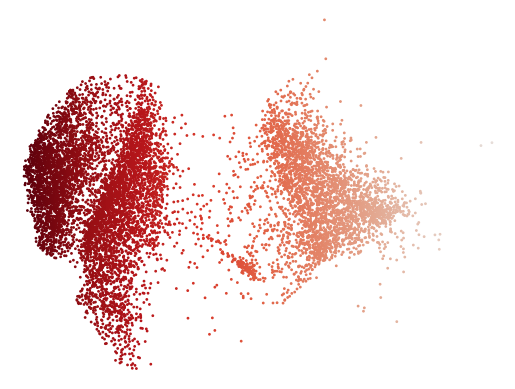

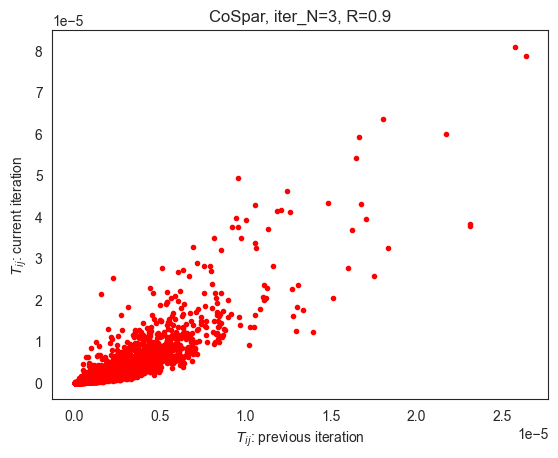

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.023656368255615234
--> Phase II: time elapsed --  0.029567956924438477


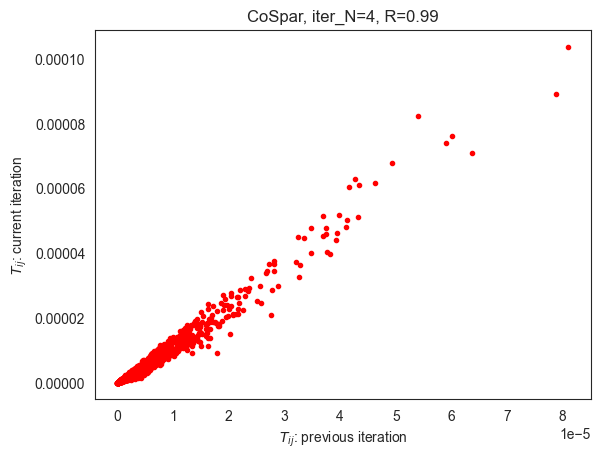

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.1370096206665039
--> Phase II: time elapsed --  0.1865065097808838
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.38818993506493504
--> Clonal cell fraction (day 2-1): 0.455459113750571
--> Numer of cells that are clonally related -- day 1: 1913  and day 2: 2991
Number of multi-time clones post selection: 115
Cell number=11495, Clone number=115
--> clonal_cell_id_t1: 1913
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.05614638328552246
--> Time elapsed:  0.3133254051208496
--> Time elapsed:  0.157684326171875
--> Time elapsed

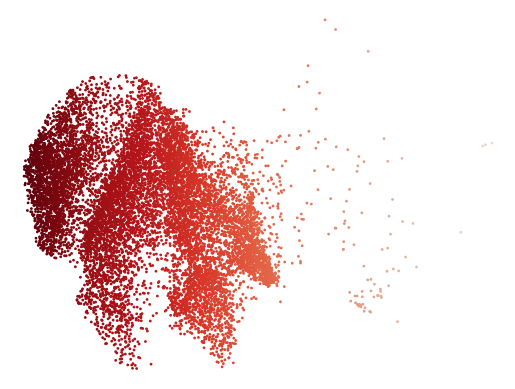

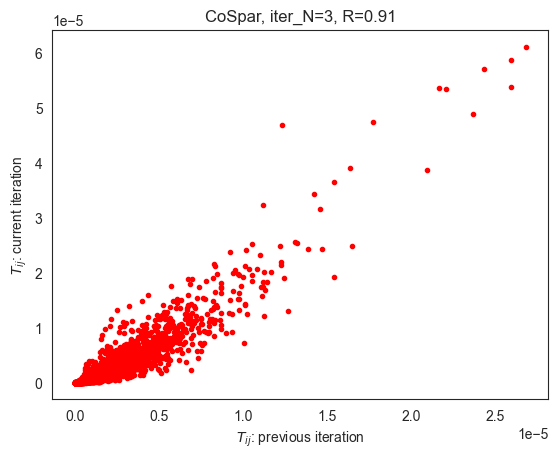

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.11733794212341309
--> Phase II: time elapsed --  0.13605952262878418


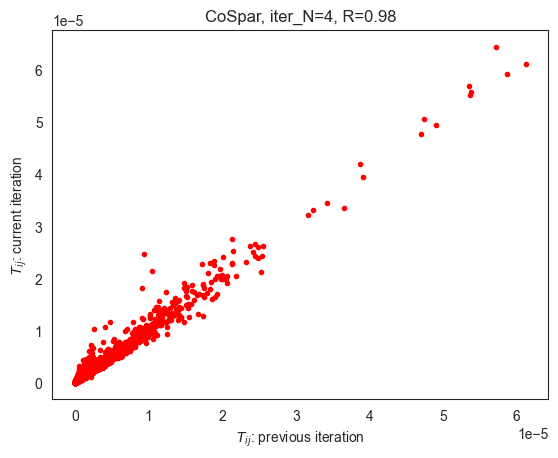

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.28794097900390625
--> Phase II: time elapsed --  0.36867856979370117
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 371.22292613983154 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.021260499954223633
Smooth round: 2
--> Time elapsed: 0.20299983024597168
Smooth round: 3
--> Time elapsed: 1.5070655345916748
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity m

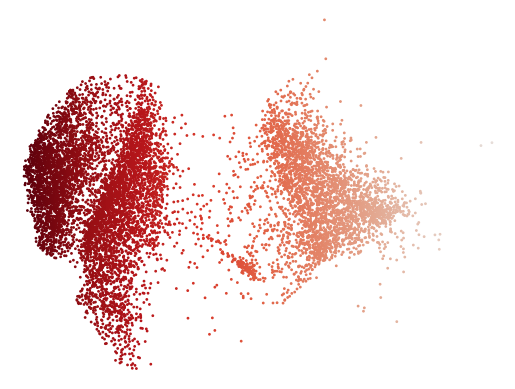

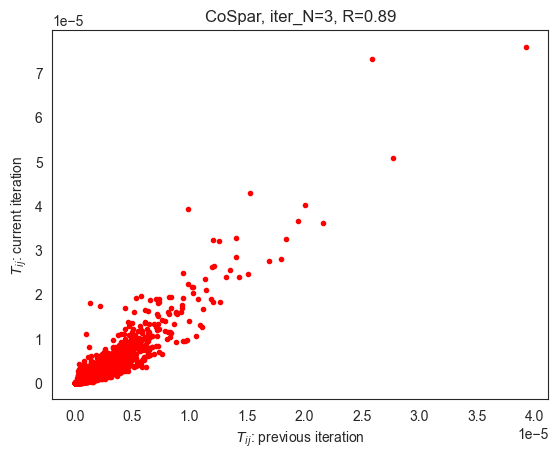

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.02436685562133789
--> Phase II: time elapsed --  0.030878067016601562


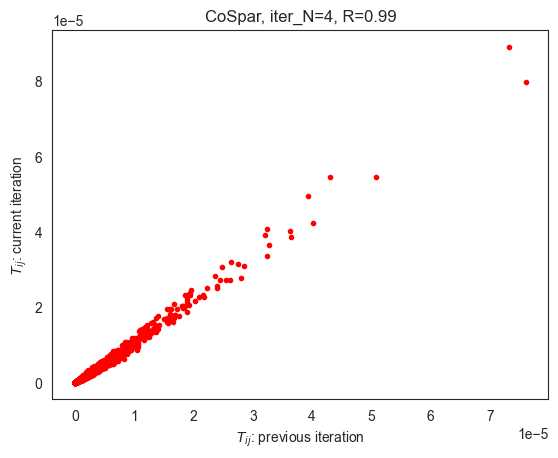

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.13306903839111328
--> Phase II: time elapsed --  0.1704721450805664
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.385349025974026
--> Clonal cell fraction (day 2-1): 0.40794883508451346
--> Numer of cells that are clonally related -- day 1: 1899  and day 2: 2679
Number of multi-time clones post selection: 103
Cell number=11495, Clone number=103
--> clonal_cell_id_t1: 1899
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.0585024356842041
--> Time elapsed:  0.26328492164611816
--> Time elapsed:  0.15511560440063477
--> Time elap

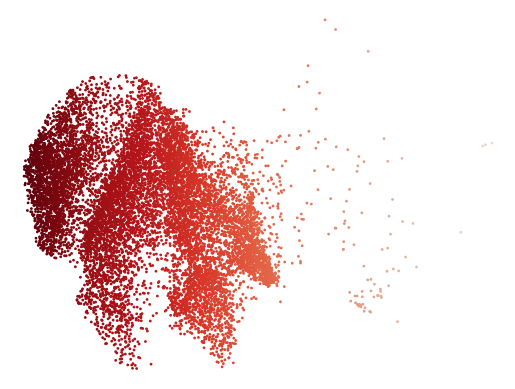

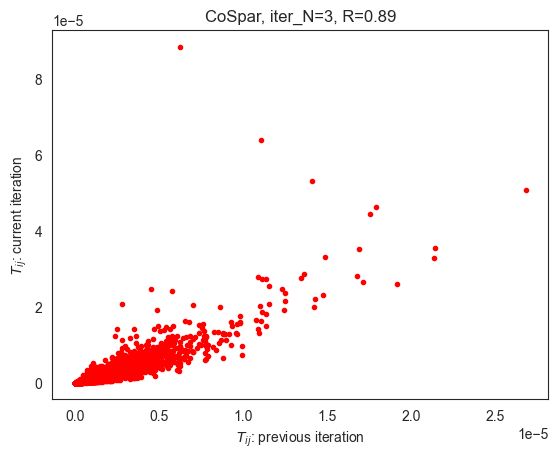

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.10780096054077148
--> Phase II: time elapsed --  0.12359237670898438


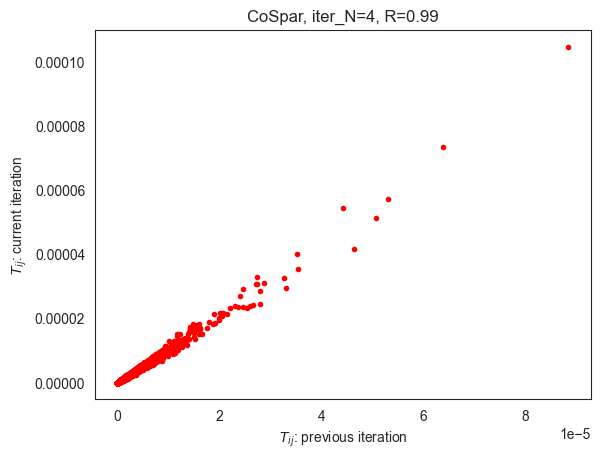

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.31673288345336914
--> Phase II: time elapsed --  0.3980288505554199
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 368.0836088657379 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.021873950958251953
Smooth round: 2
--> Time elapsed: 0.18967056274414062
Smooth round: 3
--> Time elapsed: 1.4866046905517578
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity mat

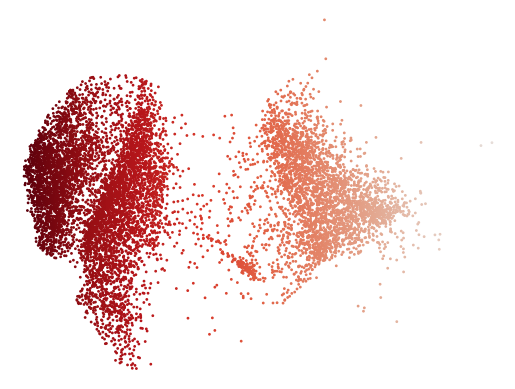

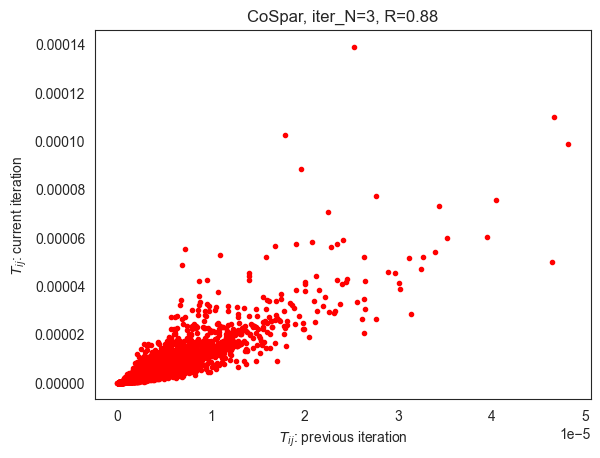

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.021410226821899414
--> Phase II: time elapsed --  0.026824951171875


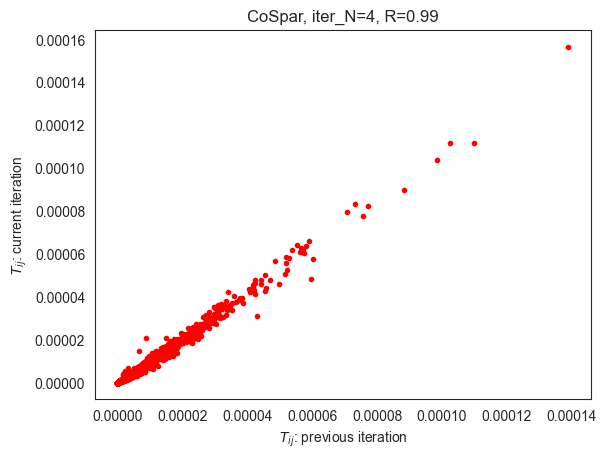

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.09044551849365234
--> Phase II: time elapsed --  0.12476801872253418
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.3216314935064935
--> Clonal cell fraction (day 2-1): 0.455459113750571
--> Numer of cells that are clonally related -- day 1: 1585  and day 2: 2991
Number of multi-time clones post selection: 109
Cell number=11495, Clone number=109
--> clonal_cell_id_t1: 1585
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.0449223518371582
--> Time elapsed:  0.3049492835998535
--> Time elapsed:  0.14566349983215332
--> Time elaps

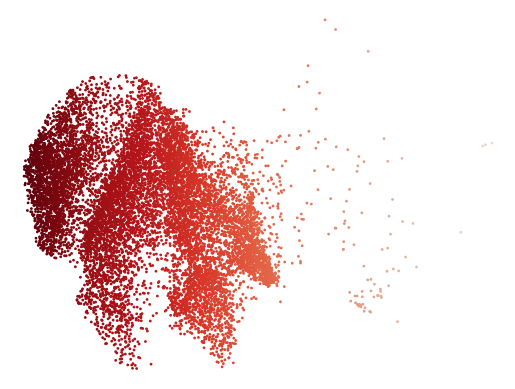

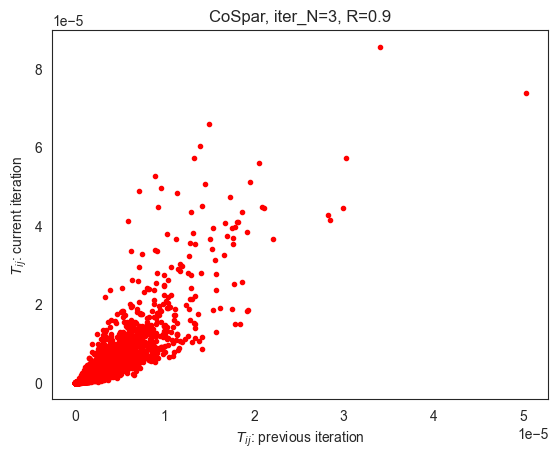

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.06635093688964844
--> Phase II: time elapsed --  0.08130359649658203


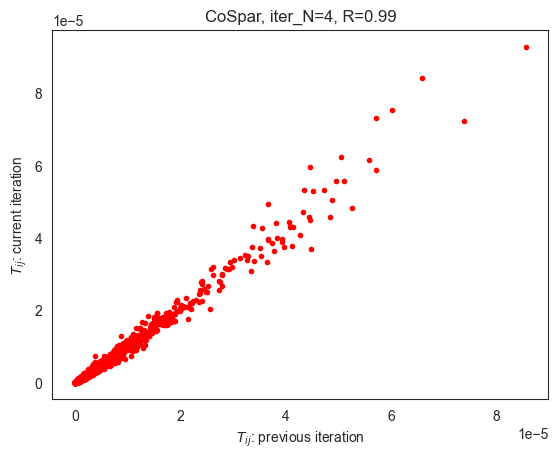

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.16368818283081055
--> Phase II: time elapsed --  0.23954129219055176
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 364.17526268959045 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.022135019302368164
Smooth round: 2
--> Time elapsed: 0.18793535232543945
Smooth round: 3
--> Time elapsed: 1.3645517826080322
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity m

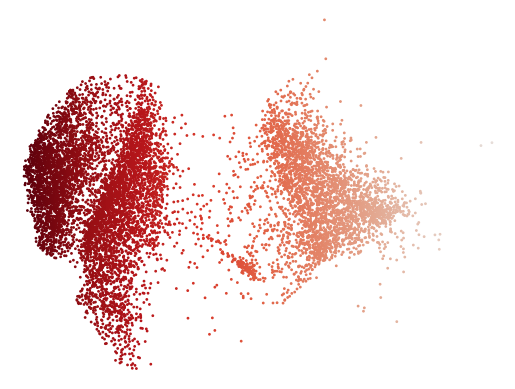

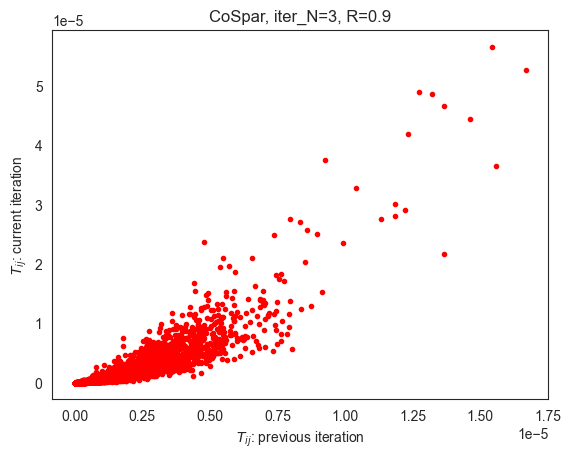

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.07430171966552734
--> Phase II: time elapsed --  0.0852057933807373


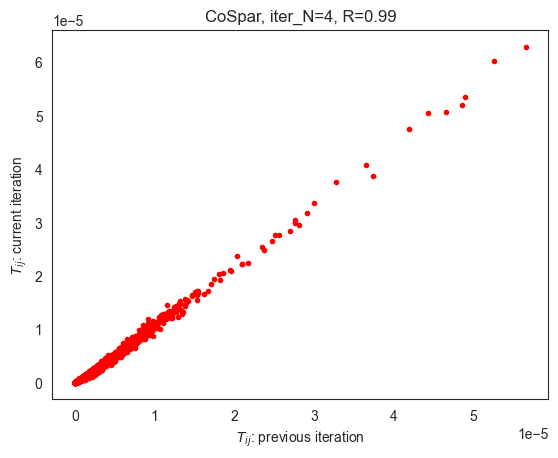

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.12957549095153809
--> Phase II: time elapsed --  0.17524337768554688
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.43445616883116883
--> Clonal cell fraction (day 2-1): 0.6814374904827166
--> Numer of cells that are clonally related -- day 1: 2141  and day 2: 4475
Number of multi-time clones post selection: 117
Cell number=11495, Clone number=117
--> clonal_cell_id_t1: 2141
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.07731819152832031
--> Time elapsed:  0.3845219612121582
--> Time elapsed:  0.16979146003723145
--> Time el

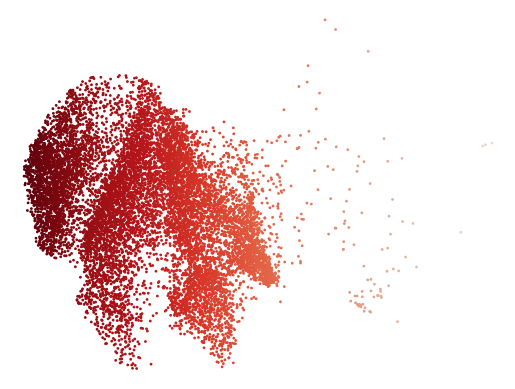

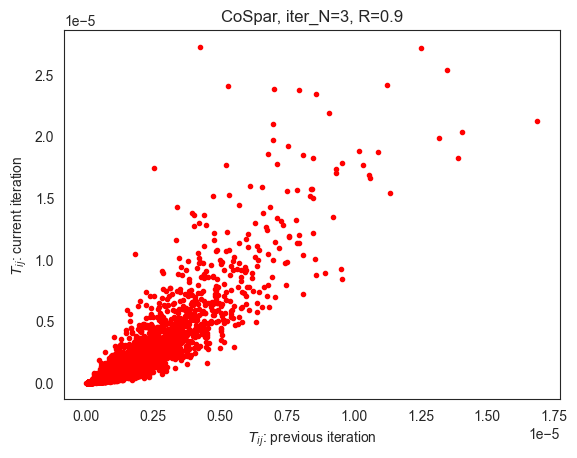

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.18391156196594238
--> Phase II: time elapsed --  0.21288728713989258


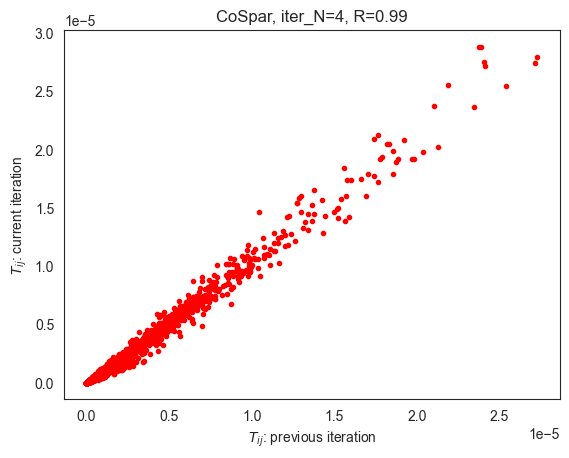

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.28009748458862305
--> Phase II: time elapsed --  0.3689401149749756
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 368.19471406936646 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.022933006286621094
Smooth round: 2
--> Time elapsed: 0.18474888801574707
Smooth round: 3
--> Time elapsed: 1.3690416812896729
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity ma

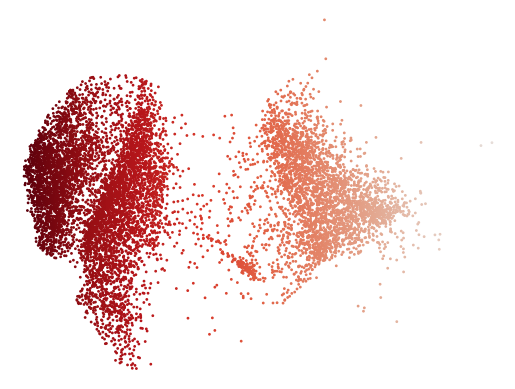

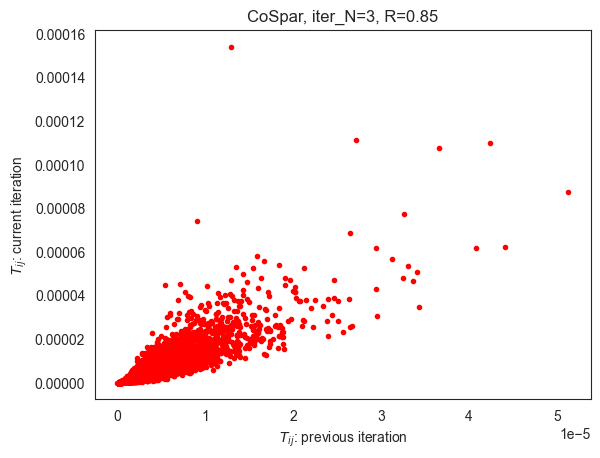

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.0329132080078125
--> Phase II: time elapsed --  0.03957772254943848


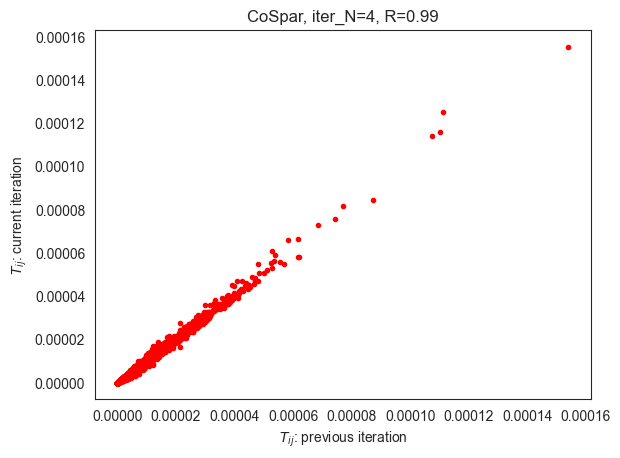

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.09537100791931152
--> Phase II: time elapsed --  0.13141274452209473
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.36160714285714285
--> Clonal cell fraction (day 2-1): 0.48911222780569513
--> Numer of cells that are clonally related -- day 1: 1782  and day 2: 3212
Number of multi-time clones post selection: 108
Cell number=11495, Clone number=108
--> clonal_cell_id_t1: 1782
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.05597043037414551
--> Time elapsed:  0.3084728717803955
--> Time elapsed:  0.15488123893737793
--> Time e

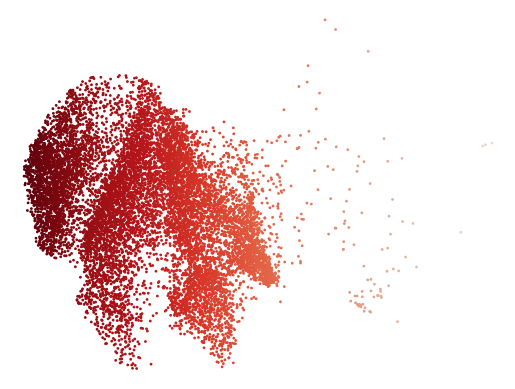

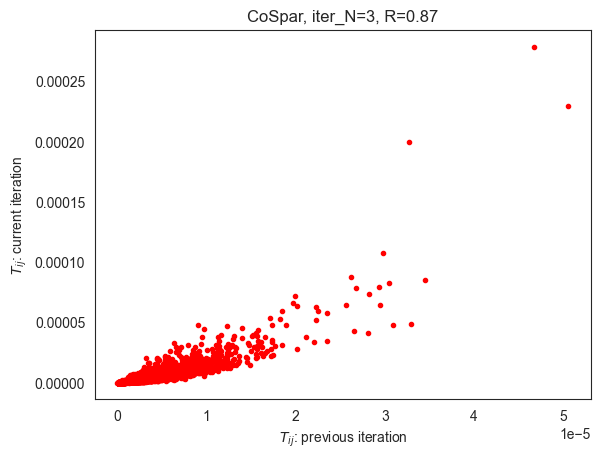

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.05444622039794922
--> Phase II: time elapsed --  0.07047295570373535


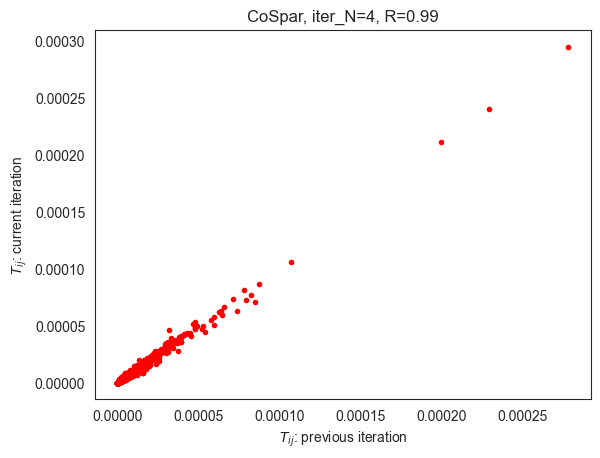

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.14641737937927246
--> Phase II: time elapsed --  0.22324442863464355
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 355.2428512573242 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.02341747283935547
Smooth round: 2
--> Time elapsed: 0.187697172164917
Smooth round: 3
--> Time elapsed: 1.3693251609802246
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity matri

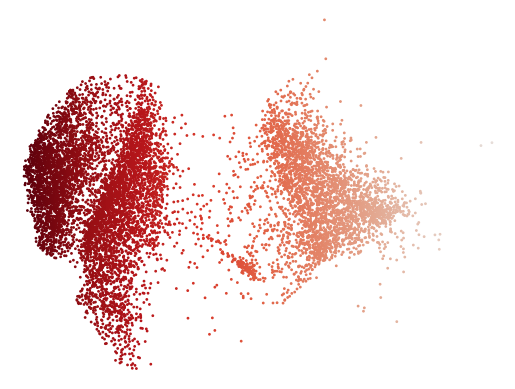

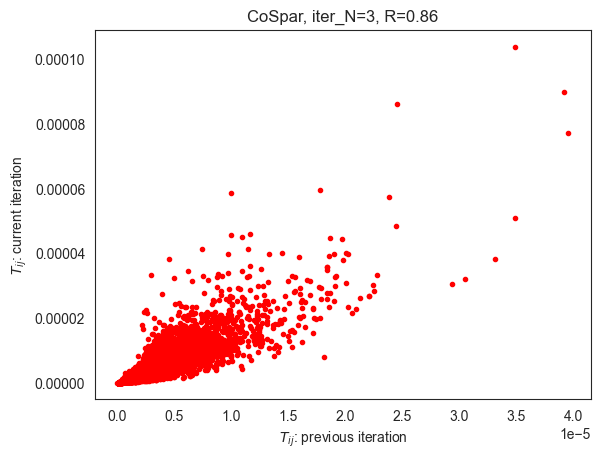

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.002514362335205078
--> Phase II: time elapsed --  0.004148244857788086


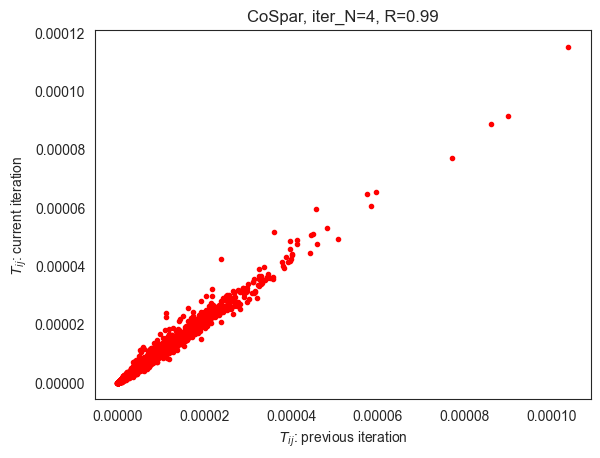

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.027023792266845703
--> Phase II: time elapsed --  0.05585932731628418
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.17796266233766234
--> Clonal cell fraction (day 2-1): 0.19993908938632557
--> Numer of cells that are clonally related -- day 1: 877  and day 2: 1313
Number of multi-time clones post selection: 105
Cell number=11495, Clone number=105
--> clonal_cell_id_t1: 877
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.020853757858276367
--> Time elapsed:  0.18463373184204102
--> Time elapsed:  0.12347555160522461
--> Time 

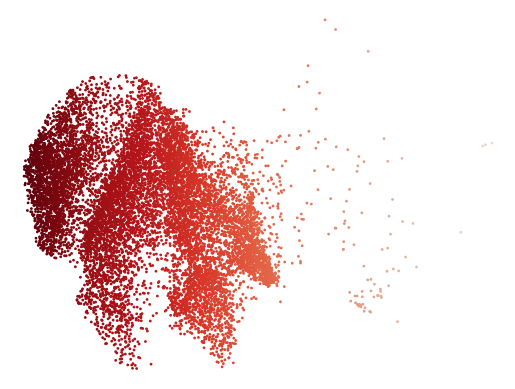

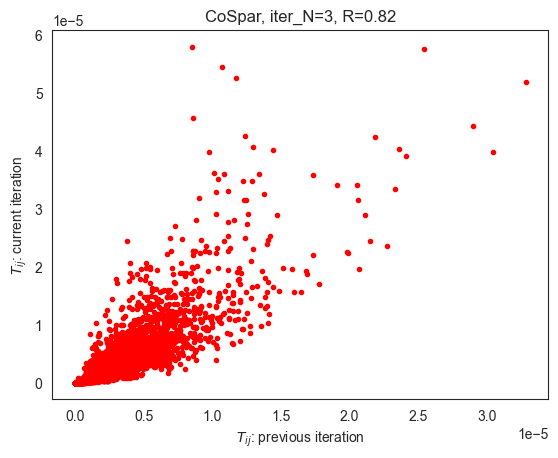

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.006954193115234375
--> Phase II: time elapsed --  0.010272741317749023


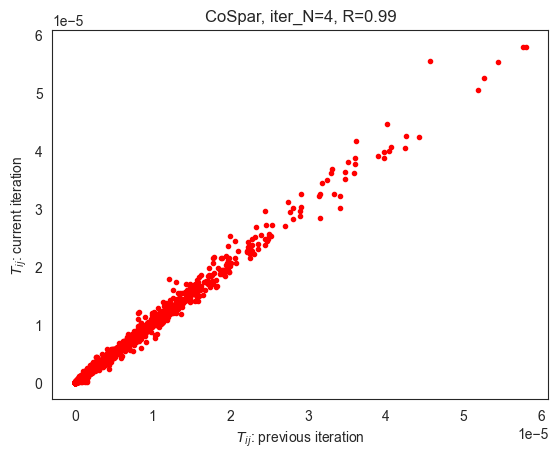

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.06402111053466797
--> Phase II: time elapsed --  0.11596274375915527
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 352.91491413116455 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.024086713790893555
Smooth round: 2
--> Time elapsed: 0.18822312355041504
Smooth round: 3
--> Time elapsed: 1.3651347160339355
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity m

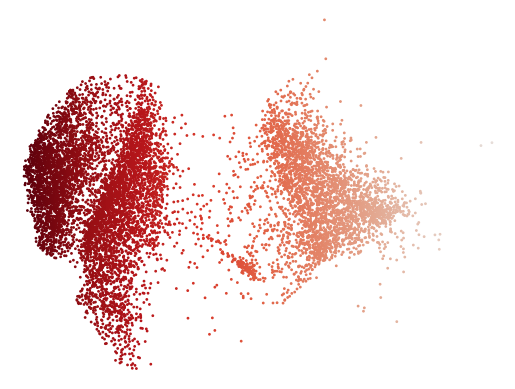

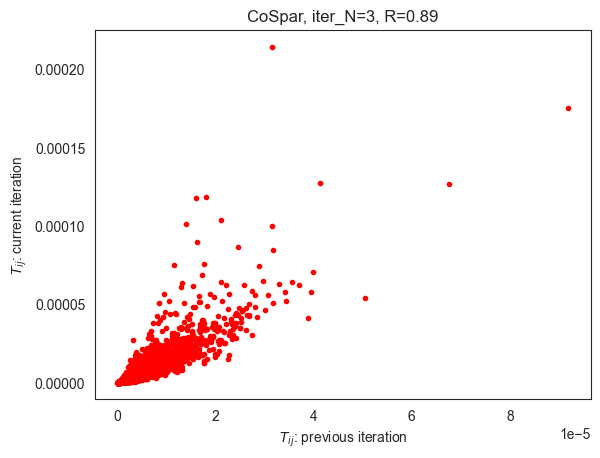

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.030652284622192383
--> Phase II: time elapsed --  0.03694486618041992


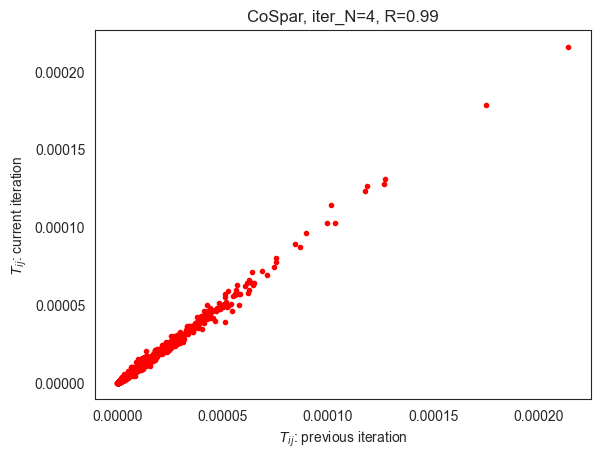

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.08430147171020508
--> Phase II: time elapsed --  0.11977243423461914
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.3804788961038961
--> Clonal cell fraction (day 2-1): 0.4382518653875438
--> Numer of cells that are clonally related -- day 1: 1875  and day 2: 2878
Number of multi-time clones post selection: 124
Cell number=11495, Clone number=124
--> clonal_cell_id_t1: 1875
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.051328182220458984
--> Time elapsed:  0.2763841152191162
--> Time elapsed:  0.15952777862548828
--> Time el

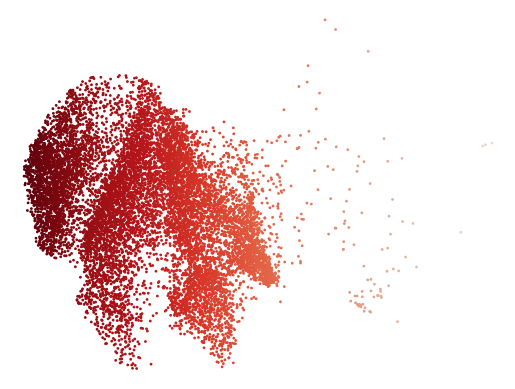

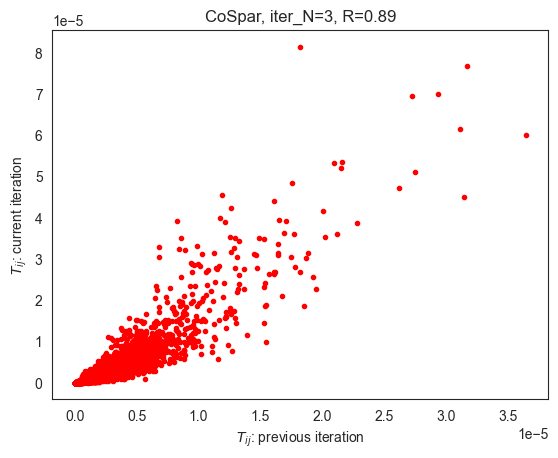

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.04654669761657715
--> Phase II: time elapsed --  0.060747385025024414


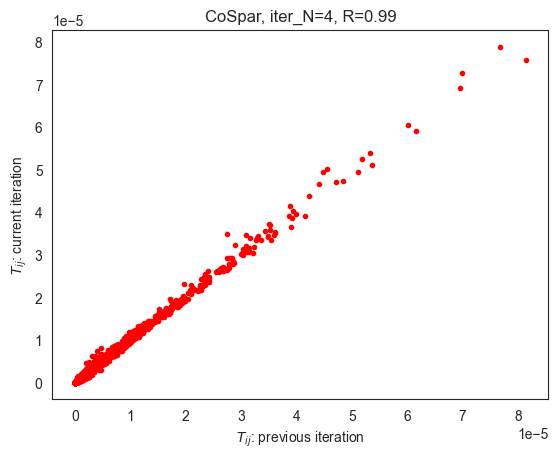

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.1605815887451172
--> Phase II: time elapsed --  0.24219131469726562
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 355.5143313407898 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.024126529693603516
Smooth round: 2
--> Time elapsed: 0.18497252464294434
Smooth round: 3
--> Time elapsed: 1.3669817447662354
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity mat

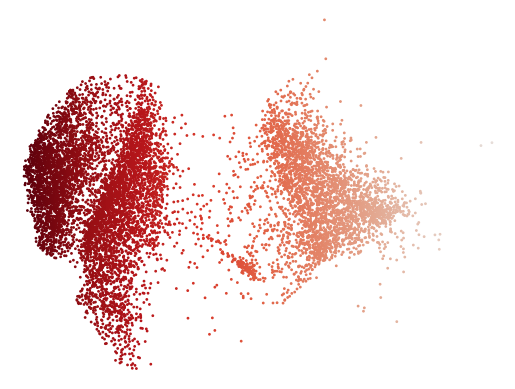

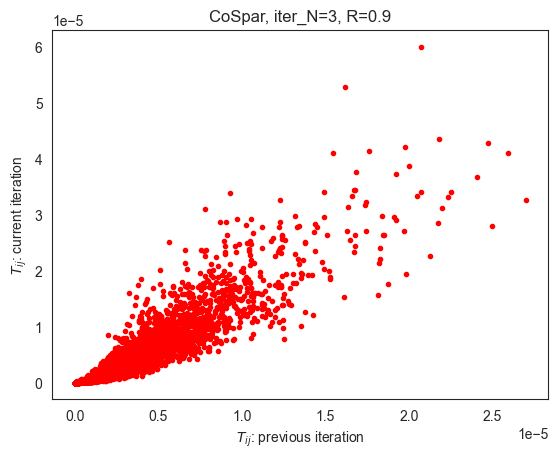

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.025732994079589844
--> Phase II: time elapsed --  0.0322418212890625


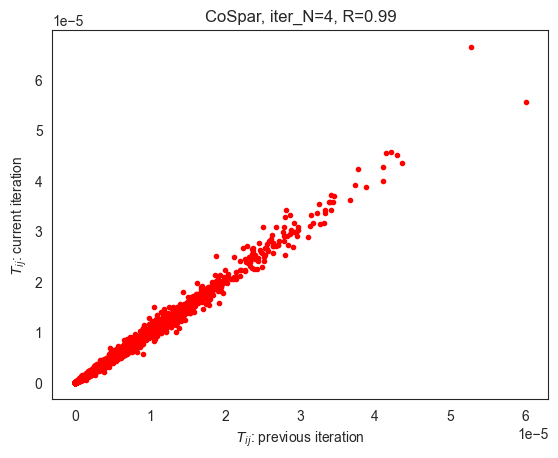

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.10588502883911133
--> Phase II: time elapsed --  0.14273715019226074
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.38453733766233766
--> Clonal cell fraction (day 2-1): 0.4569818790924319
--> Numer of cells that are clonally related -- day 1: 1895  and day 2: 3001
Number of multi-time clones post selection: 112
Cell number=11495, Clone number=112
--> clonal_cell_id_t1: 1895
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.1478900909423828
--> Time elapsed:  0.4613931179046631
--> Time elapsed:  0.4260392189025879
--> Time elap

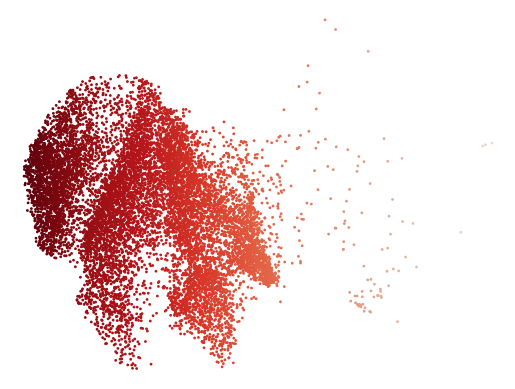

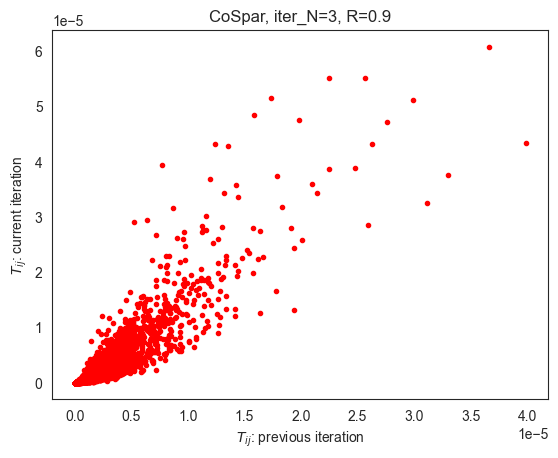

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.07221460342407227
--> Phase II: time elapsed --  0.09037232398986816


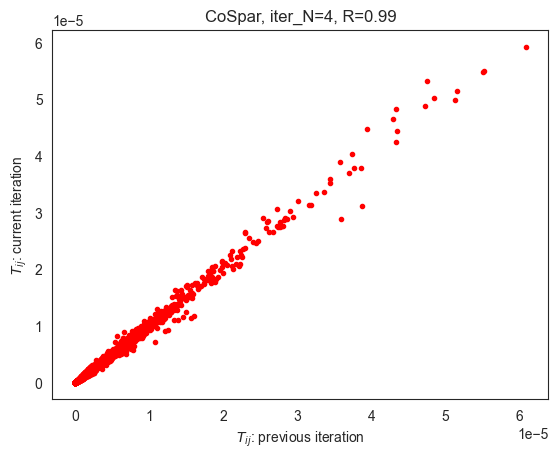

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.17709779739379883
--> Phase II: time elapsed --  0.25827980041503906
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 395.1233723163605 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Time points with clonal info: ['0' '1' '2']
------Compute the full Similarity matrix if necessary------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.0245513916015625
Smooth round: 2
--> Time elapsed: 0.18756651878356934
Smooth round: 3
--> Time elapsed: 1.3766016960144043
--> Orignal sparsity=0.13952742364935591, Thresholding
--> Final sparsity=0.08274391355144298
similarity matr

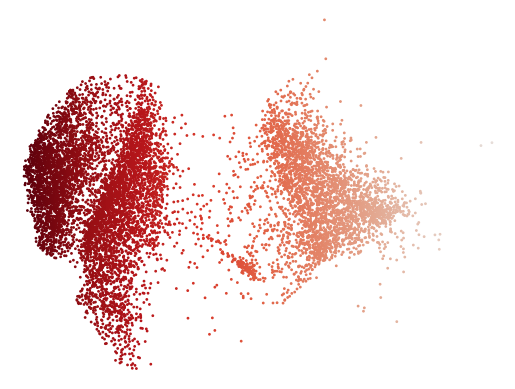

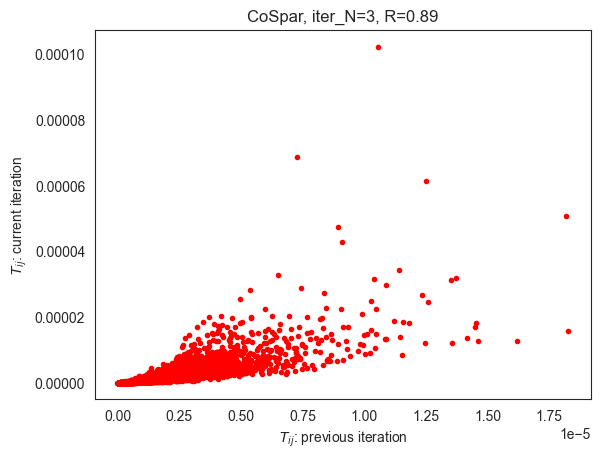

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.03398275375366211
--> Phase II: time elapsed --  0.04345130920410156


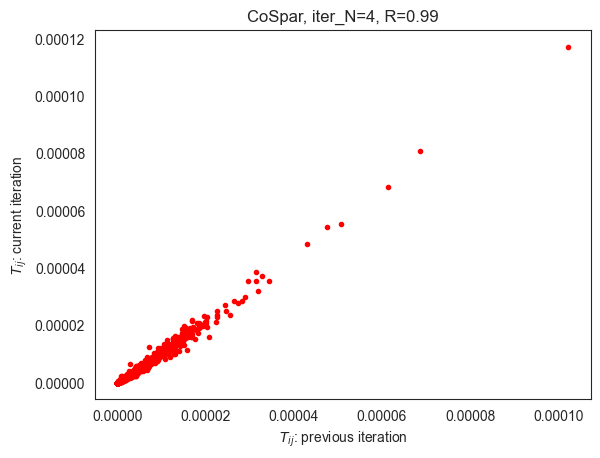

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.10396981239318848
--> Phase II: time elapsed --  0.1424560546875
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--------Current initial time point: 1--------
Step 1: Select time points
--> Clonal cell fraction (day 1-2): 0.5202922077922078
--> Clonal cell fraction (day 2-1): 0.5448454393178012
--> Numer of cells that are clonally related -- day 1: 2564  and day 2: 3578
Number of multi-time clones post selection: 126
Cell number=11495, Clone number=126
--> clonal_cell_id_t1: 2564
--> Tmap_cell_id_t1: 4928
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
--> Load from hard disk--------
--> Compute similarity matrix: load existing data
--> Time elapsed:  0.09227395057678223
--> Time elapsed:  0.3389883041381836
--> Time elapsed:  0.17535710334777832
--> Time elapsed

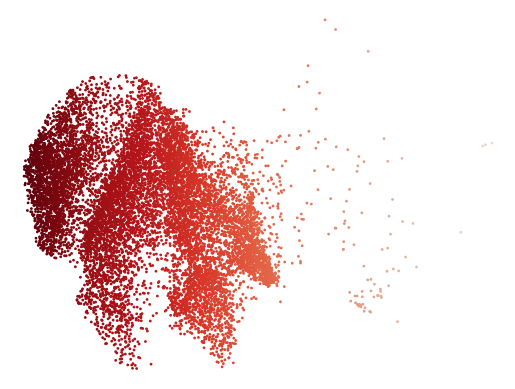

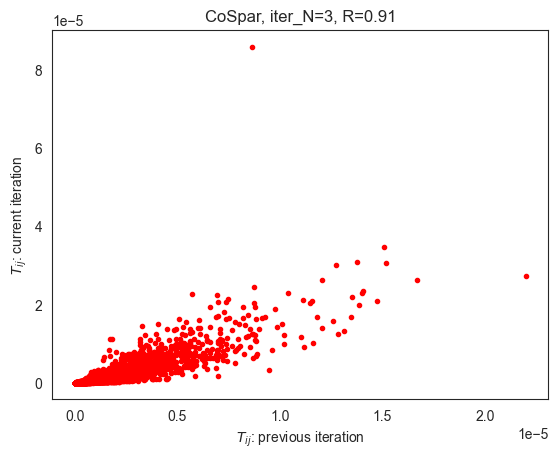

Iteration 4, Use smooth_round=5
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Start to smooth the refined clonal map
--> Phase I: time elapsed --  0.1256392002105713
--> Phase II: time elapsed --  0.16274380683898926


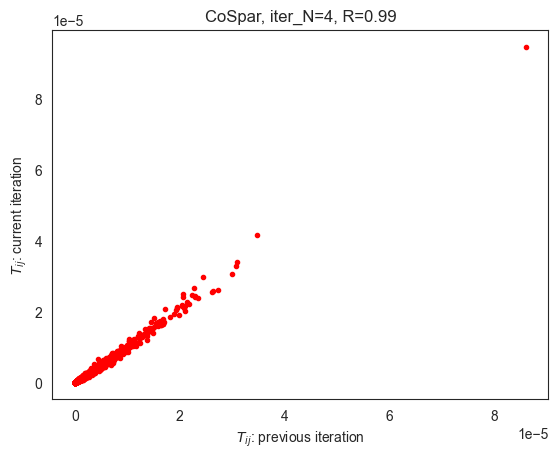

--> Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
--> Phase I: time elapsed --  0.28673815727233887
--> Phase II: time elapsed --  0.3872990608215332
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
-----------Total used time: 500.79128861427307 s ------------
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']


In [285]:
for e in range(10):
    adata_orig = adata.copy()
    generate_clone_matrix(adata_orig, 'clone')
    selected_clone = np.random.choice(range(adata_orig.obsm['X_clone'].shape[1]), size=int(0.5 * adata_orig.obsm['X_clone'].shape[1]), replace=False)
    adata_orig.obsm['X_clone'] = adata_orig.obsm['X_clone'][:,selected_clone]
    adata_orig = cs.pp.initialize_adata_object(adata_orig, time_info=adata_orig.obs[time_key], state_info=adata_orig.obs[cell_type_key])
    
    adata_lineage = cs.tmap.infer_Tmap_from_multitime_clones(
            adata_orig,
            clonal_time_points=["0", "1", "2"],
            later_time_point="2",
            smooth_array=[15, 10, 5],
            sparsity_threshold=0.2,
            intraclone_threshold=0.2,
            compute_new=True
                
    )
    cs.tl.fate_bias(
            adata_lineage,
            selected_fates=["Reprogrammed", "Failed"],
            source="transition_map",
            map_backward=True,
            method="norm-sum",
    )
    
    adata_lineage.obs.to_csv('../pygot_data/03_cellfate/reprogram/cospar_pc30_{}.csv'.format(e))

In [18]:
cospar_dfs = []
for e in range(10):
    cospar_dfs.append(pd.read_csv('../pygot_data/03_cellfate/reprogram/cospar_pc30_{}.csv'.format(e),index_col=0))

### WOT

In [53]:
import wot
for e in [1e-1, 5e-1, 1e-2, 5e-2, 2e-2, 3e-2, 5e-3]:
    ot_model = wot.ot.OTModel(adata, epsilon = e, lambda1 = 50, lambda2 = 1, growth_iters = 1, day_field=time_key,) 
    ot_model.compute_all_transport_maps(tmap_out='../pygot_data/03_cellfate/reprogram/serum_pc30_{}'.format(e))


2025-02-25 14:46:36,966 - INFO - Computing transport map from 0 to 1
2025-02-25 14:46:53,441 - INFO - Computing transport map from 1 to 2
2025-02-25 14:47:23,851 - INFO - Computing transport map from 0 to 1
2025-02-25 14:47:38,301 - INFO - Computing transport map from 1 to 2
2025-02-25 14:48:14,081 - INFO - Computing transport map from 0 to 1
2025-02-25 14:49:09,663 - INFO - Computing transport map from 1 to 2


In [15]:
def get_wot_fate(tmap_model):
    t226 = tmap_model.get_coupling(t0=0, t1=2, covariate=None)
    t426 = tmap_model.get_coupling(t0=1, t1=2, covariate=None)
    def row_normalizing(X):
        return X / np.sum(X, axis=1)[:,None]
    
    
    
    def calcu_fate(chain, start_index):
        
        P0 = chain @ (adata.obs[adata.obs[time_key]==2][cell_type_key] == 'Failed').astype(int).to_numpy()
        P1 = chain @ (adata.obs[adata.obs[time_key]==2][cell_type_key] == 'Reprogrammed').astype(int).to_numpy()
        P2 = chain @ (adata.obs[adata.obs[time_key]==2][cell_type_key] == 'Others').astype(int).to_numpy()
        
        return pd.DataFrame([P0, P1, P2], columns=start_index, index=['Failed','Reprogrammed','Others' ]).T
    
    
    fate1 = calcu_fate(t226.X, t226.obs.index)
    fate2 = calcu_fate(t426.X, t426.obs.index)
    return pd.concat([fate1, fate2])

In [16]:
import wot
wot_dfs = []
for e in [1e-1, 5e-1, 1e-2, 5e-2, 2e-2, 3e-2, 5e-3]:
    tmap_model = wot.tmap.TransportMapModel.from_directory('../pygot_data/03_cellfate/reprogram/serum_pc30_{}'.format(e))
    wot_dfs.append(get_wot_fate(tmap_model))


## Moscot

In [ ]:
## run with [benchmark]03_cell_fate_reprogramming_run_moscot.py

In [14]:
moscot_dfs = []
for e in [1e-1, 5e-1, 1e-2, 5e-2, 1e-3, 5e-3, 1e-4]:
    moscot_dfs.append(pd.read_csv('../pygot_data/03_cellfate/reprogram/moscot_v4.0_{}.csv'.format(e),index_col=0))
    

## Cell fate computation

In [7]:
got_dfs = []
for got in gots:
    adata.obsm[velocity_key] = pygot.tl.traj.latent_velocity(adata, got, embedding_key=embedding_key, time_key=time_key)
    cellfate = pygot.tl.analysis.CellFate()
    cellfate.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, cell_type_key=cell_type_key,
                 sde=True, D=1.,
                 target_cell_types=['Reprogrammed', 'Failed'], mutual=False)
    adata.obs['got_fate_bias'] = hf.get_fate_bias(adata.obsm['descendant'],['Reprogrammed', 'Failed'] )
    got_dfs.append(adata.obs.copy())

2025-03-27 22:31:14 	 Compute transition roadmap among [0 1]
2025-03-27 22:31:14 	 Compute transition between 0 and 1
2025-03-27 22:31:14 	 Compute velocity graph
Scale factor: 16.83202190394941
Scale factor: 16.83202190394941
2025-03-27 22:31:44 	 Convert into markov chain
2025-03-27 22:31:44 	 Solve abosorbing probabilities
2025-03-27 22:31:45 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']
2025-03-27 22:31:45 	 Compute transition roadmap among [0 1]
2025-03-27 22:31:45 	 Compute transition between 0 and 1
2025-03-27 22:31:45 	 Compute velocity graph
Scale factor: 17.924989272876857
Scale factor: 17.924989272876857
2025-03-27 22:31:53 	 Convert into markov chain
2025-03-27 22:31:53 	 Solve abosorbing probabilities
2025-03-27 22:31:53 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']
2025-03-27 22:31:54 	 Compute transition roadmap among [0 1]
2025-03-27 22:31:54 	 Compute transition 

In [19]:
#GOT
pred_bias_gots = [df.loc[x0_adata.obs.index]['got_fate_bias'].to_numpy() for df in got_dfs]

#WOT
pred_bias_wot = [df.loc[x0_adata.obs.index].apply(lambda x: x['Reprogrammed'] / (x['Reprogrammed'] + x['Failed']), axis=1 ).to_numpy() for df in wot_dfs] 


#MOSCOT
pred_bias_moscot = [df.loc[x0_adata.obs.index.to_series().astype(int)]['moscot_fate_bias'].to_numpy() for df in moscot_dfs]

#Cospar
pred_bias_cospars = [df.loc[x0_adata.obs.index.to_series().astype(int)]['fate_bias_transition_map_Reprogrammed*Failed'].to_numpy() for df in cospar_dfs]
#    pred_bias_cospars.append(pd.read_csv('./benchmark_model/Cospar/03_cell_fate/reprogramming_fate/cospar_{}.csv'.format(i), index_col=0).loc[x0_adata.obs.index.to_series().astype(int)]['fate_bias_transition_map_Reprogrammed*Failed'].to_numpy())



## Benchmarking

In [20]:
gots_res = [hf.correlation_2x2(pred_bias_gots[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_gots))]
wot_res = [hf.correlation_2x2(pred_bias_wot[i],  x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_wot))]
moscot_res = [hf.correlation_2x2(pred_bias_moscot[i],  x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_moscot))]
cospar_res = [hf.correlation_2x2(pred_bias_cospars[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_cospars))]



In [21]:
pcc_df =  pd.DataFrame([np.concatenate([
            np.array(gots_res)[:,1,0],
            np.array(moscot_res)[:,1,0],
            np.array(cospar_res)[:,1,0],
            np.array(wot_res)[:,1,0],
            #np.array(cfms_res)[:,-1,0], 
            #np.array(mioflows_res)[:,-1,0],
            ]), ['GOT']*len(gots_res)  + ["Moscot"]*len(moscot_res) + ["Cospar\n(with clone)"]*len(cospar_res) + ['WOT']*len(wot_res)  
                       # + ['OT-CFM']*len(wot_res) + ['MIOFlow']*len(mioflows_res) 
                       ], index=['PCC', 'Method']).T


In [22]:
import mplscience
mplscience.set_style(reset_current=True)
plt.rcParams['font.sans-serif'] = ['Arial']
pal=sns.color_palette()
paln=pal.copy()
paln[0]=np.array([13,111,178])/255

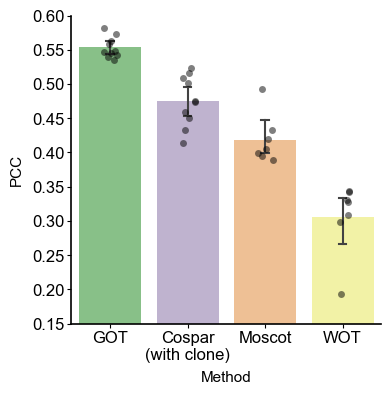

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.barplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
            capsize=.1,  
    err_kws={"linewidth": 1.5}, order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'], 
            palette='Accent')  
sns.stripplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
              color='black', alpha=.5, order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']) 
plt.ylim(0.15, 0.6)


plt.show()

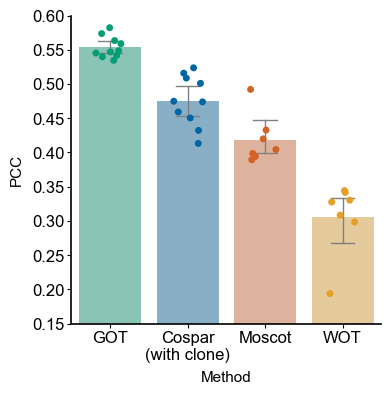

In [37]:

palette = {
    'GOT':'#049e74',
    'Cospar\n(with clone)':'#0066a4',
    'Moscot': '#d46126',
    'WOT':'#e5a023',
}
#palette = 'Accent'

ax = sns.barplot(
    x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    capsize=.3,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)


sns.stripplot(
    x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    dodge=False,  
    jitter=0.2,  
    palette=palette, 
    alpha=1.,
    legend=False,
    #ax=ax,
    size=5,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']
)
plt.ylim(0.15, 0.6)

plt.show()

In [38]:
#pcc_df.to_csv('./results/03_cellfate/reprogram_res.csv')

SCC: 0.7325729433904445
PCC: 0.7511677274567782
Mean Squared Error: 0.06924743856156756
R-squared: 0.5641581037874424
ROC-AUC: 0.8757280006337049


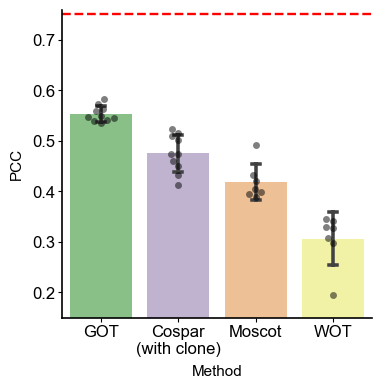

In [80]:
scc, pcc, mse, r2, auc = hf.positive_control(x0_adata, embedding_key, groundtruth_key)
pcc_df = pd.concat([pcc_df, pd.DataFrame([pcc, 'supervised LR'], index=['PCC', 'Method']).T])
sns.barplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
            capsize=.1, ci="sd", order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'], 
            palette='Accent')  
sns.swarmplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
              color="black", alpha=.5, order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']) 
plt.ylim(0.15, 0.76)
plt.axhline(y=pcc_df.loc[pcc_df['Method'] == 'supervised LR']['PCC'].tolist()[0], color='red', linestyle='--', label='supervised linear regression')
plt.show()
plt.close()

## Visulization

In [39]:
show_idx = (x0_adata.obsm['X_emb'][:,0]< 2) & (x0_adata.obsm['X_emb'][:,0] > -7)

In [41]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 5, figsize=(6.4*4, 4.8))

custom_cmap='coolwarm'

norm = mcolors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)


sc.pl.embedding(x0_adata[show_idx], color=groundtruth_key, ax=axes[0], basis='emb', cmap='coolwarm', colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_gots[np.array(gots_res)[:,1,0].argsort()[len(gots_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[1], basis='emb', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_cospars[np.array(cospar_res)[:,1,0].argsort()[len(cospar_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[2], basis='emb', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_moscot[np.array(moscot_res)[:,1,0].argsort()[-3]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[3], basis='emb', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_wot[np.array(wot_res)[:,1,0].argsort()[-3]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[4], basis='emb', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)
#plt.show()
plt.savefig('/disk/share/xuruihong/pygot_fig/benchmark_cell_fate_reprogram_example.jpg', format='jpg', dpi=300)


     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.446090       0.449794       0.540475          0.554741
pcc    0.548687       0.553311       0.642252          0.660236
mse    0.137102       0.134615       0.095523          0.090888
r2    -1.018956      -1.130812      -0.406668         -0.438666
auc    0.804857       0.806950       0.822993          0.831659
     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.459430       0.457587       0.563101          0.568309
pcc    0.474853       0.471115       0.557521          0.562707
mse    0.196183       0.198374       0.153549          0.153819
r2    -0.990103      -1.195334      -0.557619         -0.702267
auc    0.807669       0.806631       0.848163          0.849994
     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.401858       0.405658       0.489655          0.501248
pcc    0.419887       0.420161       0.490569          0.497431
mse    0.206352       0.199849       0.1

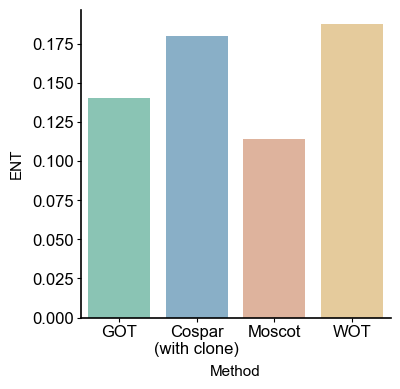

In [64]:
def ent(x):
    return -np.sum(np.log(x[(x>0.05)&(x<0.95)])*x[(x>0.05)&(x<0.95)]) / len(x)
    
ent_df =  pd.DataFrame([np.concatenate([
            [ent(x) for x in pred_bias_gots],
            [ent(x) for x in pred_bias_moscot],
            [ent(x) for x in pred_bias_cospars],
            [ent(x) for x in pred_bias_wot],
            
            ]), ['GOT']*len(gots_res)  + ["Moscot"]*len(moscot_res) + ["Cospar\n(with clone)"]*len(cospar_res) + ['WOT']*len(wot_res)  
                       # + ['OT-CFM']*len(wot_res) + ['MIOFlow']*len(mioflows_res) 
                       ], index=['ENT', 'Method']).T


palette = {
    'GOT':'#049e74',
    'Cospar\n(with clone)':'#0066a4',
    'Moscot': '#d46126',
    'WOT':'#e5a023',
}
#palette = 'Accent'
# 先画条形图
ax = sns.barplot(
    x='Method', y='ENT', data=ent_df.loc[ent_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    capsize=.3,
    errorbar=None,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)




plt.show()

In [66]:
ent_df.to_csv('./results/03_cellfate/reprogram_ent.csv')

In [69]:
ent_df1, ent_df2, ent_df3 = pd.read_csv('./results/03_cellfate/reprogram_ent.csv'), pd.read_csv('./results/03_cellfate/hpsc_ent.csv'), pd.read_csv('./results/03_cellfate/cancer_ent.csv')
ent_df1['Dataset'] = 'Reprograme'
ent_df2['Dataset'] = 'HPSC'
ent_df3['Dataset'] = 'Cycling-Cancer'

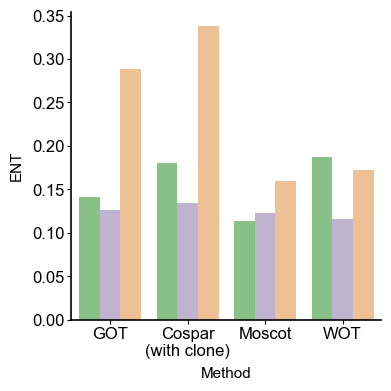

In [75]:
#Predicted Entropy of all datasets
palette = 'Accent'

ax = sns.barplot(
    x='Method', y='ENT', data=pd.concat([ent_df1, ent_df2, ent_df3]), 
    hue='Dataset',
    capsize=.3,
    errorbar=None,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,    
)

plt.show()

In [91]:
# Supervised performance of all datasets
sns.barplot(pd.DataFrame([
    [0.75, 0.63, 0.41],
    ['Reprogram', 'HPSC', 'Cycling Caner']], index=['R', 'Dataset']).T,
    x='Dataset', y='R',
    palette = 'Accent'
)
plt.ylim(0.35, 0.78)
